In [ ]:
import pandas as pd
import geopandas as gpd
import os
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx


#Define The Study area
mahallatPop = gpd.read_file("data/data/tehran_popblocks_95.shp")
area = ox.geocode_to_gdf("Yousef Abad, Tehran, Iran")

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((51.39445 35.72874, 51.39681 35.72891...",51.394445,35.721397,51.413572,35.751329,196760238,relation,8321681,35.73466,51.404566,boundary,administrative,22,0.133416,neighbourhood,Yousef Abad,"Yousef Abad, District 6, Tehran, بخش مرکزی شهر..."


In [36]:
#Get the Supply Data
#You can find the tags you need here https://wiki.openstreetmap.org/wiki/Map_features
place = 'Yousef Abad, Tehran, Iran'

tag_amenity = {'amenity': ['school','hospital','cafe','restaurant']}
amenities = ox.features_from_place(place, tag_amenity)
#amenities['amenity'].value_counts()



In [55]:
tag_leisure = {'leisure': ['park']}
leisure = ox.features_from_place(place, tag_leisure)
leisure['leisure'].value_counts()
facilities = gpd.GeoDataFrame(pd.concat([amenities,leisure], ignore_index=True))
#facilities.sample(10)
facilities.geom_type.value_counts()

Polygon    23
Point      16
Name: count, dtype: int64

In [ ]:
#Points (supply)
point = facilities[facilities.geom_type == 'Point']
point['s_j'] = 1
point[['amenity','s_j','geometry']].sample(10)

f:\Data analytics\genv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,amenity,s_j,geometry
0,cafe,1,POINT (51.40784 35.72757)
15,restaurant,1,POINT (51.41004 35.73358)
2,cafe,1,POINT (51.39928 35.7295)
10,restaurant,1,POINT (51.40992 35.72376)
12,restaurant,1,POINT (51.40921 35.73629)
11,cafe,1,POINT (51.41102 35.72542)
1,cafe,1,POINT (51.4111 35.72532)
8,school,1,POINT (51.40962 35.72987)
7,school,1,POINT (51.40837 35.72433)
13,restaurant,1,POINT (51.40919 35.73637)


In [119]:
#Polygons (supply)
all_gdfs = []
service = [tag_amenity, tag_leisure]
for i in service:
    service_gdf = ox.features_from_place(place,i)
    service_gdf = service_gdf.to_crs(epsg=32639)
    print(i)
    print(service_gdf.geom_type.value_counts())
    service_gdf['s_j'] = service_gdf.apply(
        lambda row: row.geometry.area if row.geometry.geom_type in ['Polygon','MultiPolygon'] else 1,
        axis=1
    )
    
    all_gdfs.append(service_gdf)


supply = pd.concat(all_gdfs, ignore_index=True)
supply = gpd.GeoDataFrame(supply, geometry='geometry', crs='epsg:32639')

#service_gdf.sample(10)
len(supply)
type(supply)
#supply[['amenity','leisure','s_j']].sample(10)

{'amenity': ['school', 'hospital', 'cafe', 'restaurant']}
Point      16
Polygon     6
Name: count, dtype: int64
{'leisure': ['park']}
Polygon    17
Name: count, dtype: int64


geopandas.geodataframe.GeoDataFrame

In [121]:
#Yousef Abad Pop (Demand)
mahallatPop['NAME_MAHAL'].unique()
yousefAbadPop = mahallatPop[mahallatPop['NAME_MAHAL'] == 'يوسف اباد']
yousefAbadPop.geom_type.value_counts()
demand = yousefAbadPop
demand = demand.to_crs(epsg=32639)
demand.geom_type.value_counts()


Polygon    172
Name: count, dtype: int64

In [131]:
#Calculating the supply-to-demand ratio (Rj)
supply = supply.to_crs(epsg=32639)
demand = demand.to_crs(epsg=32639)
radius = 1500

supply['R_j'] = 0.0
supply['demand_pop'] = 0

for idx, sup in supply.iterrows():
    nearby_demand = demand[demand.geometry.distance(sup.geometry) <= radius]
    population = nearby_demand['POPULATION'].sum()
    supply.at[idx, 'demand_pop'] = population

    if population > 0:
        supply['R_j'] = supply['s_j'] / population
    else:
        supply['R_j'] = 0

#supply.sample(10)

C:\Users\Sazgar\AppData\Local\Temp\ipykernel_14800\3361877441.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


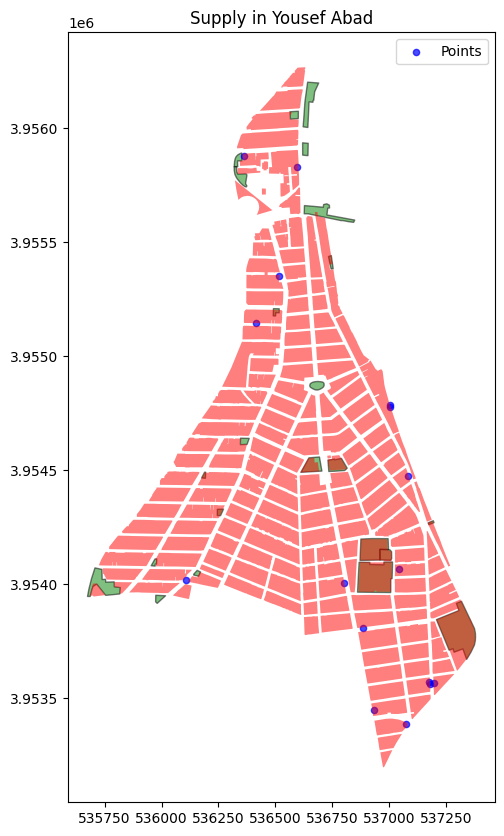

In [130]:
#Checking if the demand and supply are actually overlap
import matplotlib.pyplot as plt

# Points
points = supply[supply.geom_type == 'Point']
# Polygons
polygons = supply[supply.geom_type.isin(['Polygon','MultiPolygon'])]


fig, ax = plt.subplots(figsize=(10,10))
polygons.plot(ax=ax, color='green', alpha=0.5, edgecolor='black', label='Polygons')
points.plot(ax=ax, color='blue', alpha=0.7, markersize=20, label='Points')
demand.plot(ax=ax, color='red', alpha=0.5 )
plt.title('Supply in Yousef Abad')
plt.legend()
plt.show()

In [132]:
#Calculating the accebility at each demand point
demand['A_i'] = 0.0

for idx, dem in demand.iterrows():
    nearby_supply = supply[supply.geometry.distance(dem.geometry) <= 1500 ]
    nearby_supply['R_j']
    demand.at[idx, 'A_i'] = nearby_supply['R_j'].sum()

#demand.sample(10)